## Import everything, clean tweets, do sentiment analysis

In [16]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer as cntvec
from sklearn.feature_extraction.text import TfidfTransformer as tftrans
from sklearn.feature_extraction.text import CountVectorizer as cntvec
from sklearn.feature_extraction.text import TfidfTransformer as tftrans
#Silence warnings
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

W0403 16:35:11.236409 12612 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [6]:
tweets = pd.read_csv(r"C:\Users\Cole\Downloads\politcian_trialdata.csv")

In [7]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment_polarity(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.polarity

In [8]:
def Convert(string): 
    li = list(string.split("', '")) 
    return li

In [11]:
for x in range(0, len(tweets['Comments'])):
    tweets['Comments'][x] = Convert(tweets['Comments'][x])

AttributeError: 'list' object has no attribute 'split'

In [12]:
tweets['Comments'][0] == ['[]']

True

In [13]:
tweets['Avg_Sent'] = np.NaN
tweets['SD_Sent'] = np.NaN
for x in range(0, len(tweets['Comments'])):
    for y in range(0, len(tweets['Comments'][x])):
        if tweets['Comments'][x]!= ['[]']:
            tweets['Comments'][x][y] = analize_sentiment_polarity(clean_tweet(tweets['Comments'][x][y]))
    try:
        tweets['Avg_Sent'][x] = np.mean(tweets['Comments'][x])
    except: 
        tweets['Avg_Sent'][x] = np.NaN
    try:
        tweets['SD_Sent'][x] = np.std(tweets['Comments'][y])  
    except:
        tweets['SD_Sent'][x] = np.NaN

TypeError: 'str' object does not support item assignment

In [35]:
print(tweets.comments)

AttributeError: 'list' object has no attribute 'comments'

In [21]:
# Import the Universal Sentence Encoder's TF Hub module
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)


Message: Elephant
Embedding size: 512
Embedding: [-0.016987269744277, -0.00894981063902378, -0.007062731310725212, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.03531336411833763, -0.02538427710533142, -0.007880033925175667, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [0.01879093423485756, 0.045365191996097565, -0.020010899752378464, ...]



In [31]:
# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.016987269744277, -0.00894981063902378, -0.007062731310725212, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.03531336411833763, -0.02538427710533142, -0.007880033925175667, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [0.01879093423485756, 0.045365191996097565, -0.020010899752378464, ...]



In [28]:
tweets = [['trump is great'], ['trump sucks'], ['provo!']] 
  
# Create the pandas DataFrame 
alltweets = pd.DataFrame(tweets, columns = ['Tweets']) 

In [30]:
alltweets['Embeddings'] = message_embeddings

ValueError: Wrong number of items passed 512, placement implies 1

In [22]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  plot_similarity(messages_, message_embeddings_, 90)

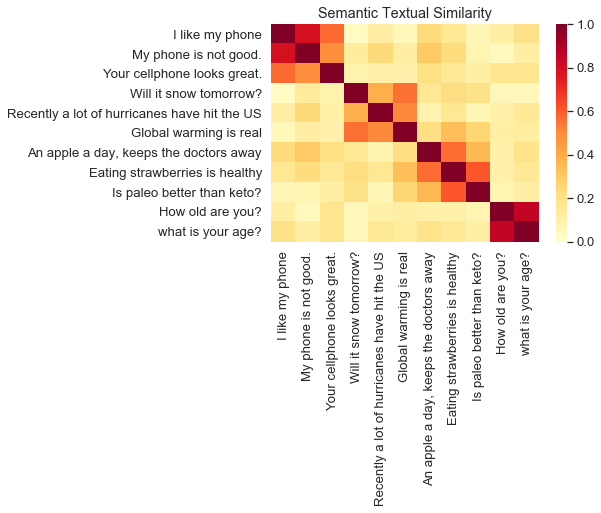

In [23]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)